In [71]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr

In [50]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

In [3]:
# training
BATCH_SIZE = 100
trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:01, 7521593.48it/s]                              


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 61943.56it/s]            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2569642.90it/s]          
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 15593.41it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


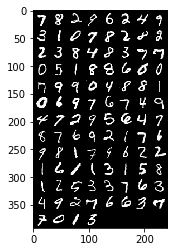

In [6]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [72]:
class VAE(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2m = nn.Linear(400, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(400, latent_variable_dim) # use for standard deviation
        
        self.fc3 = nn.Linear(latent_variable_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) - 0.5 # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        x = input.view(-1, 784)
        x = torch.relu(self.fc1(x))
        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        
        x = self.decode(z)
        
        return x, m, log_s
    
    def decode(self, z):
        x = torch.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x

In [73]:
def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return KLD + CE

In [77]:
vae = VAE(40)
optimizer = torch.optim.Adam(vae.parameters())

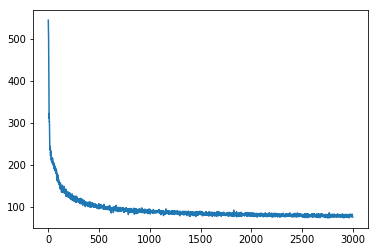

In [78]:
## train
train_loss = []
for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        optimizer.zero_grad()
        recon_image, s, mu = vae(images)
        l = loss(images, recon_image, mu, s)
        l.backward()
        train_loss.append(l.item() / len(images))
        optimizer.step()
        
        if(i%100 == 0):
            print("Epoch no :", epoch, "datapoint :", i)
            clr(wait = True)
        
plt.plot(train_loss)
plt.show()

In [79]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

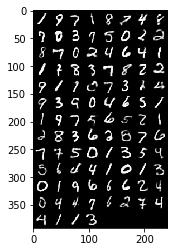

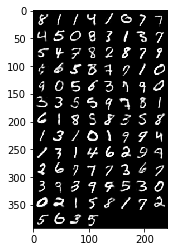

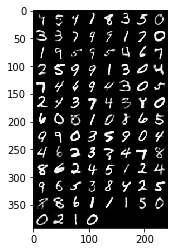

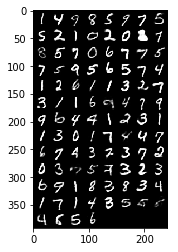

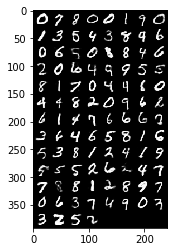

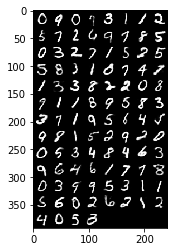

In [80]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu = vae(images)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)